In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
trans_df = pd.read_csv('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/Trans_BLR.csv', usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], sep =';', encoding = 'utf-8')
#Type_List = ['COL', 'RET']
#trans_df = trans_df.loc[trans_df['T_DOC_TYPE'].isin(Type_List)]
trans_df = trans_df.loc[trans_df['T_DOC_TYPE'] == 'COL']

trans_df['T_EFFECTIVE_DATE'] = pd.to_datetime(trans_df['T_EFFECTIVE_DATE'])
trans_df['Date'] = trans_df.apply(lambda r:r['T_EFFECTIVE_DATE'].date(), axis = 1)
trans_df = trans_df.dropna(subset = ['Date'])

trans_df = trans_df[['Date', 'T_DOC_TYPE', 'T_SENDING_ID', 'T_RTI_NAME', 'T_ACT_HAND_OUT_QTY']]
trans_df = trans_df.reset_index()
trans_df = trans_df.drop('index', axis = 1)
#trans_df.head()

In [3]:
depot_add = pd.read_excel('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/masterdata20190918.xlsx', sheet_name = 'Depot Account_Addreses')
depot_add = depot_add[['name', 'code', 'country']]
#depot_add.head()

In [4]:
# JOIN

trans_full = trans_df.join(depot_add.set_index('code'), on = 'T_SENDING_ID')
trans_full = trans_full.drop(['T_SENDING_ID', 'T_DOC_TYPE'], axis =1)
trans_full.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name,country
0,2014-12-22,CC Euro Container Base,60,NL-Bleiswijk-CCNL,NL
1,2014-12-22,CC Euro Container Post 170,240,NL-Bleiswijk-CCNL,NL
2,2014-07-09,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL
3,2014-07-09,CC Container Shelf,30,NL-Bleiswijk Bloemenveiling Holland,NL
4,2014-07-04,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL


In [5]:
trans_full['country'].unique()

array(['NL', nan, 'IT', 'AT', 'DE', 'ES', 'LV', 'CH', 'SE', 'GB', 'FR',
       'DK', 'PL', 'CZ', 'NO', 'PT', 'FI', 'BE', 'IE', 'UK'], dtype=object)

In [6]:
trans_full['T_RTI_NAME'].nunique()

83

In [7]:
trans_full['T_RTI_NAME'].unique()

array(['CC Euro Container Base', 'CC Euro Container Post 170',
       'CC Container Base', 'CC Container Shelf', 'CC Container Post 180',
       'CC Euro Rolly', 'CC Dolly', 'CBL 17',
       'CC Euro Container Post 110', 'Chep blok', 'CC Euro Dolly',
       'CC Adapter Tray Euro Dolly', 'CC Rolly', 'CBL 8',
       'CC Euro Trolley w/castors', 'CC Roll Container', 'CBL 7',
       'CBL 11', 'CC Minitainer', 'Eurocrate Rewe VRC 115',
       'CC Euro Container Shelf', 'CC Low Noise Rolly',
       'CC Eurocrate 222 (VRC222)', 'CC Container Base NON Tagged',
       'CC Euro Trolley Post 1175mm', 'CC Euro Trolley Shelf',
       'CC Euro Trolley Post 1792mm', 'CC ½ Container Base', 'CBL 15',
       'CBL 23', 'CC Container Post 110', 'CC Container Grille',
       'CC Container Extensions 33', 'CC ½ Container Shelf', 'DTU',
       'Pool pallet', 'CC Container Extensions 66',
       'Euro pallet wood 80 x 120', 'Metro not readable', 'Chep euro',
       'IPP Blokpallet', 'CC Eurocrate 115 (VRC115)

# Filter Dataset:

### _ONLY AT

In [8]:

trans_nl = trans_full.loc[trans_full['country'] == 'AT']
trans_nl = trans_nl.sort_values('Date', ascending = True)
trans_nl = trans_nl.drop(['country'], axis = 1)
trans_nl.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name
9935,2014-07-01,CC Euro Dolly,3,A-Hörsching Schachinger
45354,2014-07-02,CC Euro Dolly,120,A-Hörsching Schachinger
196,2014-07-07,CC Euro Dolly,100,A-Hörsching Schachinger
199,2014-07-07,CC Adapter Tray Euro Dolly,1000,A-Hörsching Schachinger
200,2014-07-07,CC Euro Dolly,20,A-Hörsching Schachinger


### _RTI = Container Base

In [9]:
nl_cb = trans_nl.loc[trans_nl['T_RTI_NAME'] == 'CC Container Base']
nl_cb = nl_cb.drop(['T_RTI_NAME'], axis = 1)
nl_cb['Date'] = pd.to_datetime(nl_cb['Date'])
nl_cb = nl_cb.set_index('Date')
nl_cb

,T_ACT_HAND_OUT_QTY,name
Date,,
2014-07-31,80,A-Hörsching Schachinger
2015-01-19,90,A-Hörsching Schachinger
2015-02-27,30,A-Hörsching Schachinger
2015-02-27,55,A-Hörsching Schachinger
2015-03-06,30,A-Hörsching Schachinger
...,...,...
2019-04-16,20,A-Graz Q Logistics
2019-04-25,50,A-Graz Q Logistics
2019-05-03,43,A-Hörsching Schachinger


Text(0.5, 1.0, 'CB_AT Jul 2014--Jul 2019')

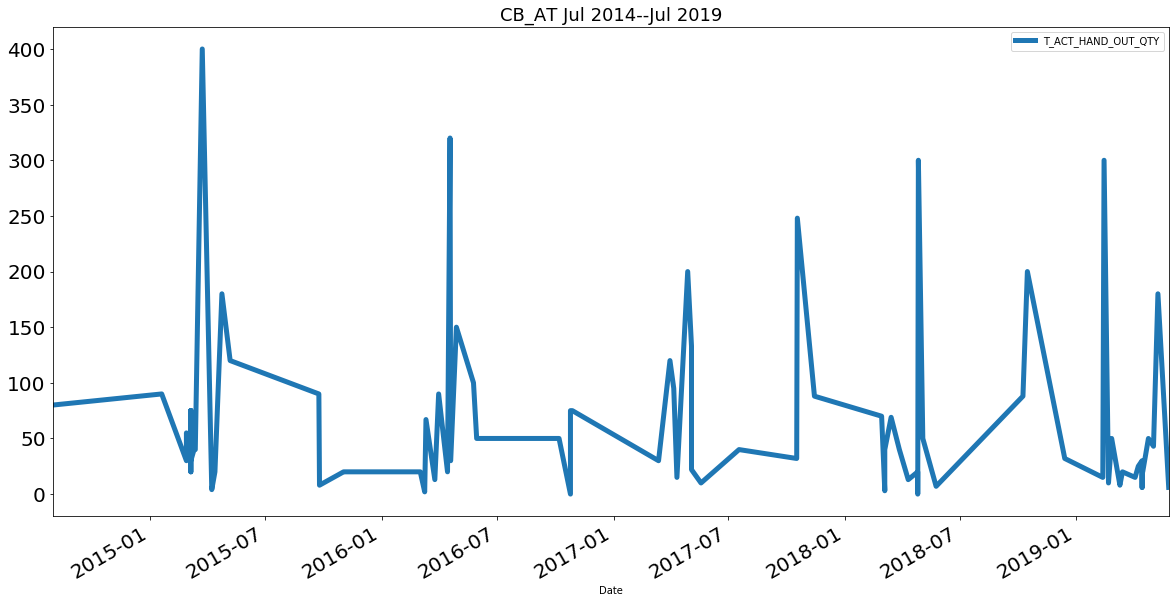

In [10]:
nl_cb.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title("CB_AT Jul 2014--Jul 2019", fontsize = 18)

## Monthly from 2016 on

Text(0.5, 1.0, 'CB_AT : Jan 2016--Jul 2019')

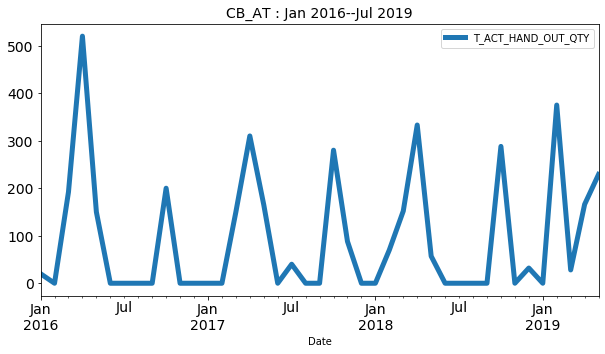

In [11]:
import datetime
nl_cbm = nl_cb.resample('1M').sum()
nl_cb_m = nl_cbm[(nl_cbm.index >= datetime.datetime(2016,1,31))]
nl_cb_m.plot(figsize=(10,5), linewidth=5, fontsize=14)
plt.title("CB_AT : Jan 2016--Jul 2019", fontsize = 14)

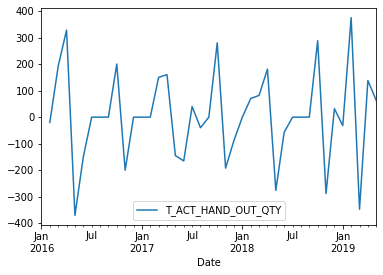

In [12]:
nl_cb_mdiff = nl_cb_m.diff()
nl_cb_mdiff.plot()

## Seasonal Decompose 2016

In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl
result = seasonal_decompose(nl_cb_m)
#fig = result.plot()
#plot_mpl(fig)

Text(0.5, 1.0, 'Residual')

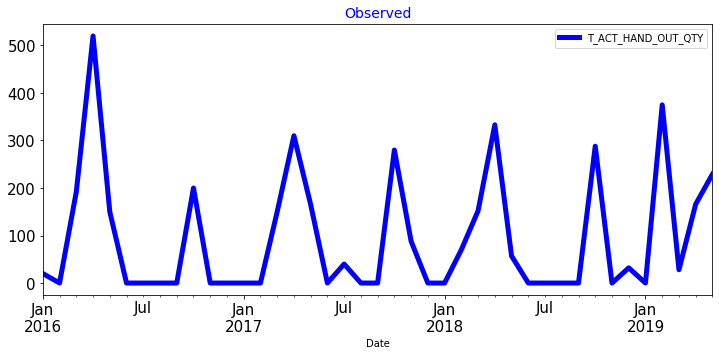

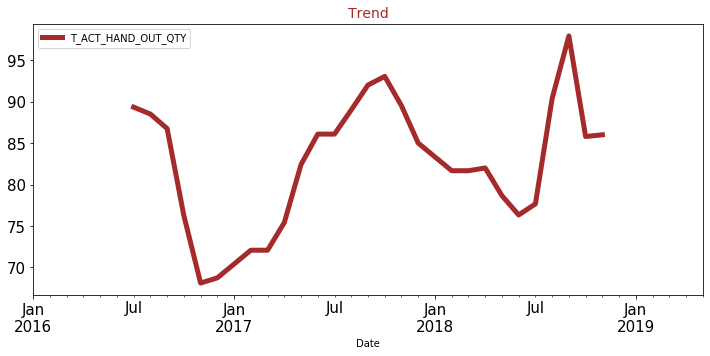

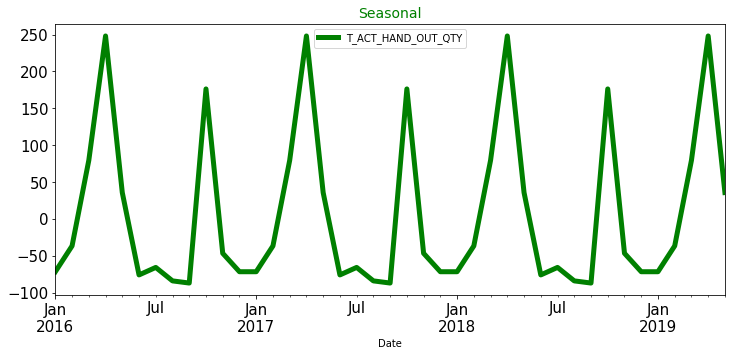

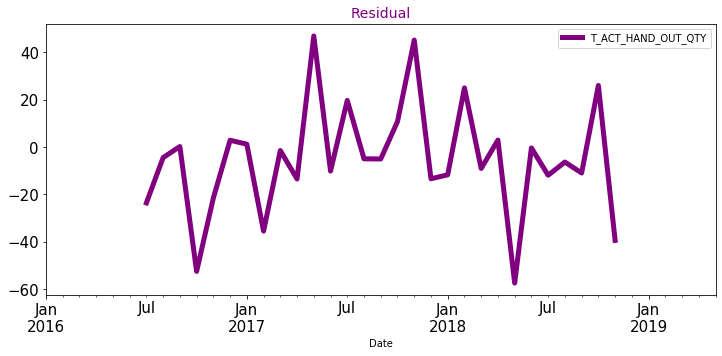

In [14]:
result.observed.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'blue')
plt.title('Observed', fontsize = 14, color ='blue')

result.trend.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'brown')
plt.title('Trend', fontsize = 14 , color = 'brown')

result.seasonal.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'green')
plt.title('Seasonal', fontsize = 14 , color = 'green')

result.resid.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'purple')
plt.title('Residual', fontsize = 14 , color = 'purple')

## SARIMA

In [15]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
stepwise_model = arima.auto_arima(nl_cb_m, start_p=1, start_q=1,
                           max_p=6, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=2, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=374.451, BIC=377.043, Fit time=0.011 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=368.400, BIC=373.583, Fit time=0.100 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=372.522, BIC=373.818, Fit time=0.010 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=366.496, BIC=370.383, Fit time=0.037 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(1, 1, 1, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(0, 1, 0, 12); AIC=359.476, BIC=364.659, Fit time=0.056 seconds
Fit ARIMA: order=(2, 2, 0) seasonal_order=(1, 1, 0, 12); AIC=360.984, BIC=367.464, Fit

In [16]:
#it_cb_m.index

In [17]:
train = nl_cb_m.loc['2016-01-31':'2018-12-31']
test = nl_cb_m.loc['2019-01-31':]

In [18]:
model_fit = stepwise_model.fit(train)
model_fit

ARIMA(maxiter=50, method='lbfgs', order=(4, 2, 3), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 0, 12),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [85]:
future_forecast = stepwise_model.predict(n_periods=5)
future_forecast

array([-72.89167215,  90.88787323, 105.7119726 , 255.11477894,
        16.03432512])

Text(0.5, 1.0, 'Austria 2019 (Prediction vs. Actual)')

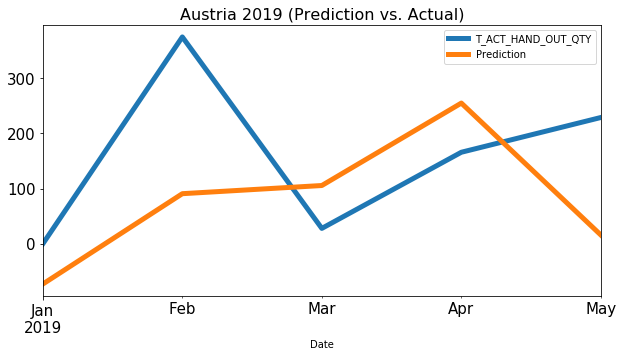

In [87]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['Prediction'])
pd.concat([test,future_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('Austria 2019 (Prediction vs. Actual)', fontsize = 16)

In [21]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, future_forecast)
mse

29073.573926879

In [22]:
model_fit.aic

<function pmdarima.arima.arima.ARIMA.aic(self)>

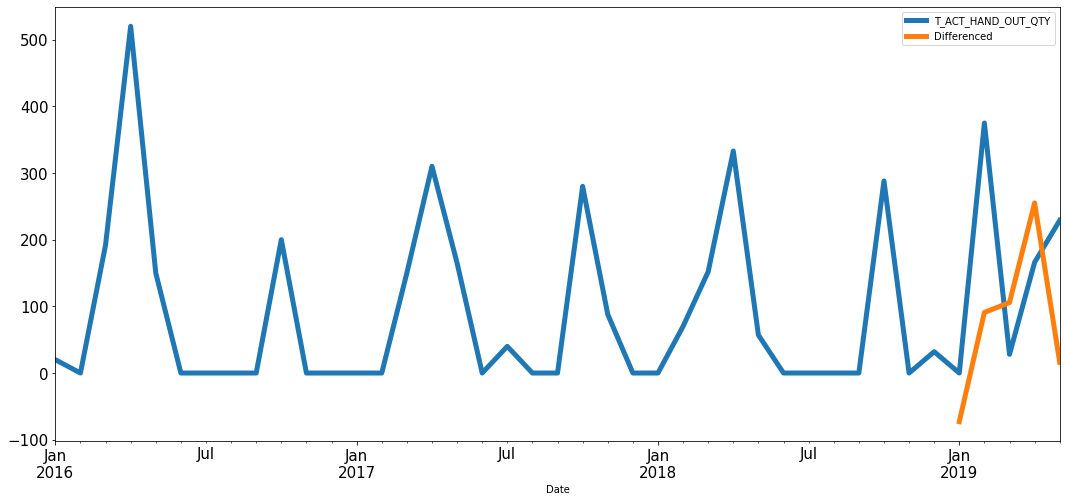

In [23]:
pd.concat([nl_cb_m,future_forecast],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)

In [24]:
nl_cb_m.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/Austria.xlsx')

In [25]:
future_forecast = future_forecast.where(future_forecast > 0, 0)
future_forecast

,Differenced
Date,
2019-01-31,0.000000
2019-02-28,90.887873
2019-03-31,105.711973
2019-04-30,255.114779
2019-05-31,16.034325


In [26]:
#future_forecast.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/2diff_SARIMA_AT.xlsx')

In [27]:
#nl_cb_m.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/AT_Monthly.xlsx')

## d&D = 0

In [28]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
nodiff_model = arima.auto_arima(nl_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(nodiff_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=513.889, BIC=522.457, Fit time=0.164 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=519.358, BIC=522.785, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=502.114, BIC=508.968, Fit time=0.108 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=512.142, BIC=518.996, Fit time=0.079 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=534.582, BIC=536.295, Fit time=0.005 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=520.690, BIC=525.831, Fit time=0.025 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=503.803, BIC=512.371, Fit time=0.285 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=503.941, BIC=512.509, Fit time=0.145 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=512.230, BIC=519.084, Fit time=0.057 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 

In [29]:
nodiff_fit = nodiff_model.fit(train)

In [30]:
nondiff_forecast = nodiff_fit.predict(n_periods=5)
nondiff_forecast

array([  9.17793232,  71.53249589, 144.57641321, 305.80749901,
        59.95236265])

Text(0.5, 1.0, 'Austria 2019 {Prediction(d & D = 0) vs. Actual}')

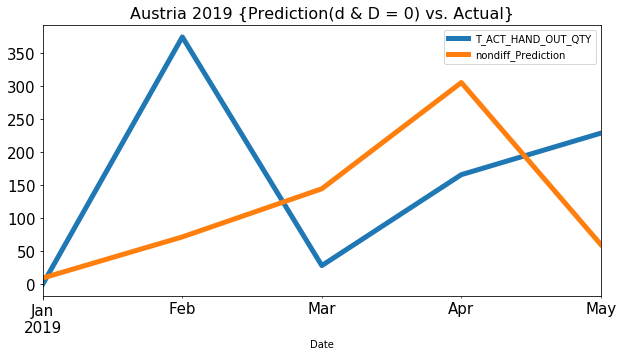

In [93]:
nondiff_forecast = pd.DataFrame(nondiff_forecast,index = test.index,columns=['nondiff_Prediction'])
pd.concat([test,nondiff_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('Austria 2019 {Prediction(d & D = 0) vs. Actual}', fontsize = 16)

In [32]:
nondiff_forecast.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/nondiff_SARIMA_AT.xlsx')

In [33]:
nondiff_mse = mean_squared_error(test, nondiff_forecast)
nondiff_mse

30778.012216359133

Text(0.5, 1.0, 'Transactions in Austria + SARIMA Result')

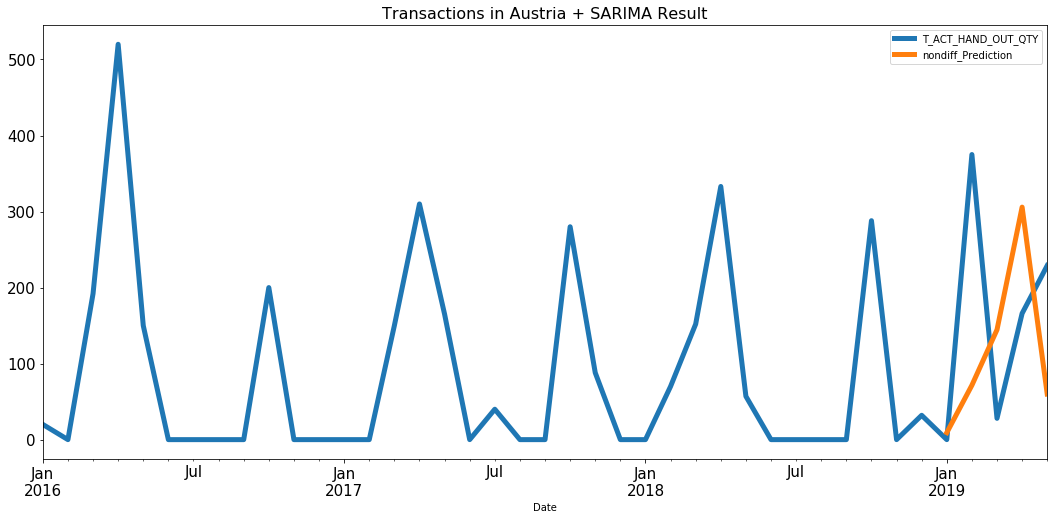

In [88]:
pd.concat([nl_cb_m,nondiff_forecast],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)
plt.title('Transactions in Austria + SARIMA Result', fontsize = 16)

## Comparison

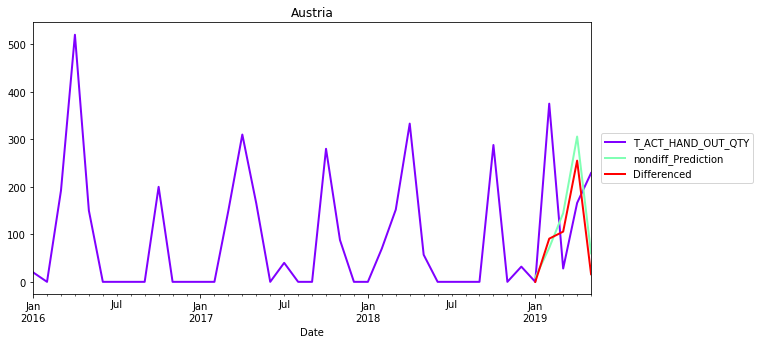

In [35]:
pd.concat([nl_cb_m, nondiff_forecast, future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='Austria')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [94]:
mse

324.3412343705263

In [95]:
nondiff_mse

30778.012216359133

In [36]:
MSEs = [mse, nondiff_mse]

In [37]:
norm = [i/sum(MSEs) for i in MSEs]
norm

[0.48576112681958805, 0.5142388731804118]

In [38]:
MSEs.index(min(MSEs))

0

In [39]:
max(MSEs)

30778.012216359133

In [40]:
mse

29073.573926879

In [41]:
from math import sqrt
sqrt(mse)

170.5097473075337

In [42]:
nondiff_mse

30778.012216359133

In [43]:
sqrt(nondiff_mse)

175.43663305125054

## DEPOTS

In [44]:
trans_at = nl_cb
#trans_at['Date'] = pd.to_datetime(trans_at['Date'])

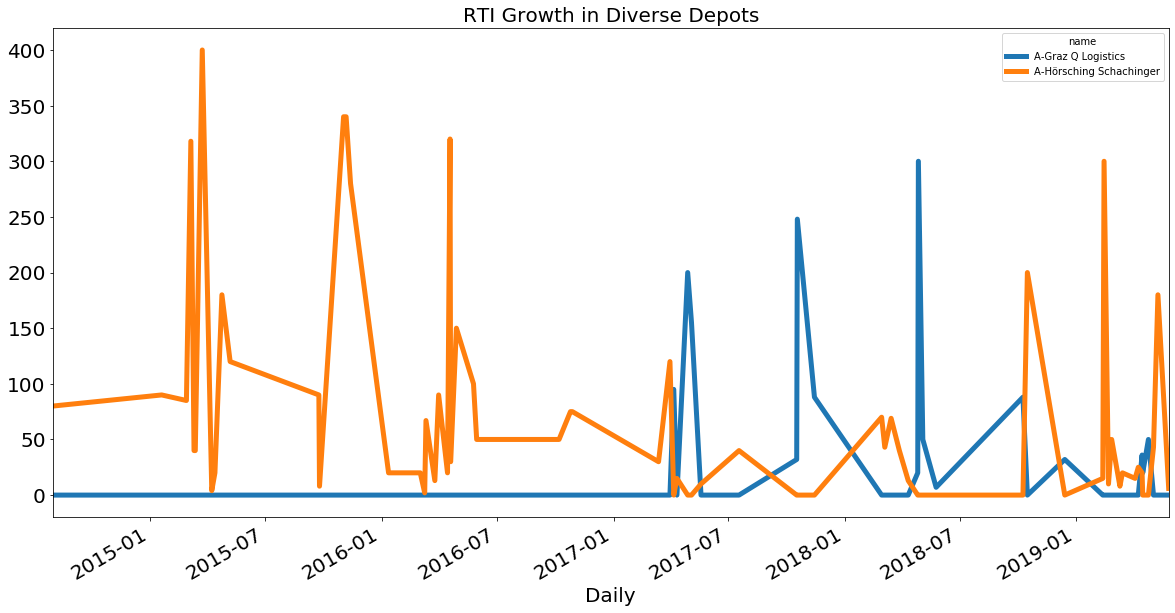

In [45]:
(trans_at.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY']
   .sum()
   .unstack('name', fill_value=0)
   .plot(figsize=(20,10), linewidth=5, fontsize=20))
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Daily', fontsize=20)
plt.show()

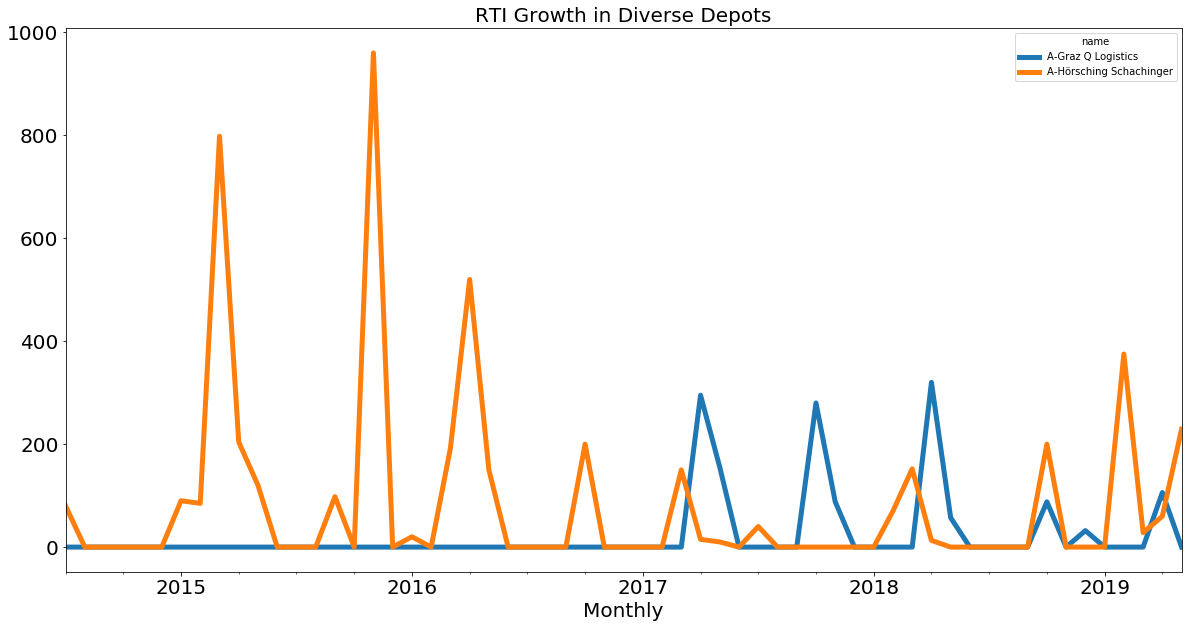

In [46]:
at_deps = trans_at.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY'].sum().unstack('name', fill_value=0)
at_deps_month = at_deps.resample('1M').sum()
at_deps_month.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Monthly', fontsize=20)
plt.show()

## From 2017 on

Text(0.5, 1.0, 'CB_AT : Jan 2016--Jul 2019')

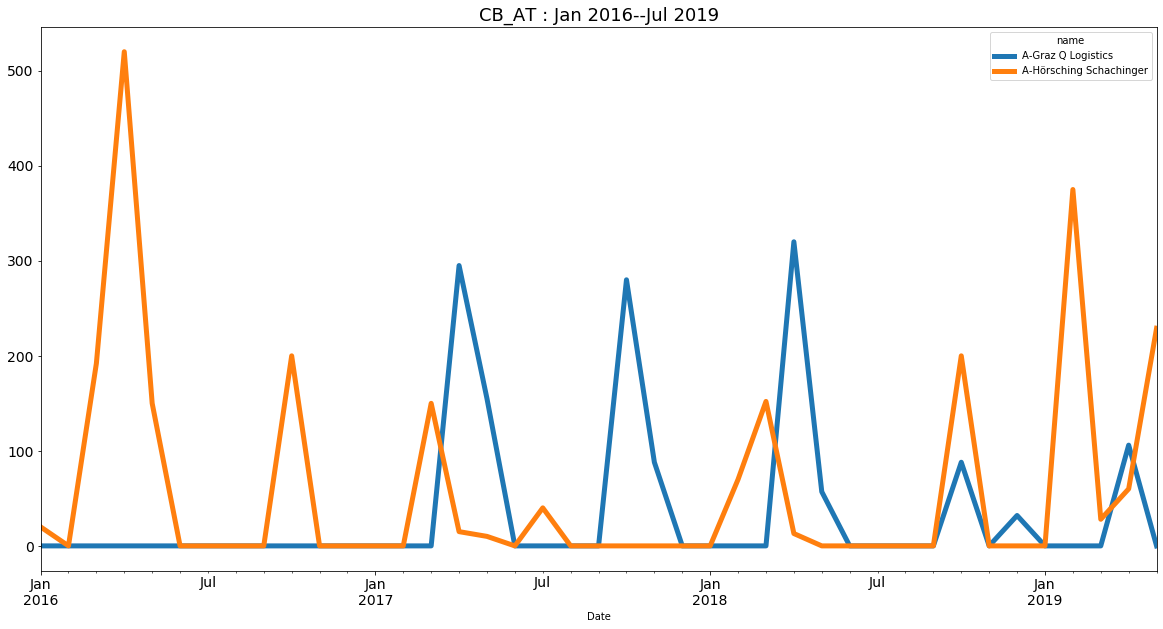

In [47]:
import datetime
at_cb2016 = at_deps_month[(at_deps_month.index >= datetime.datetime(2016,1,31))]
at_cb2016.plot(figsize=(20,10), linewidth=5, fontsize=14)
plt.title("CB_AT : Jan 2016--Jul 2019", fontsize = 18)

In [48]:
at_cb2016.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/at_cb2016.xlsx')

In [49]:
depos = trans_at['name'].unique()

In [50]:
def optimal_sarima(depot):
    
    stepwise_model = arima.auto_arima(depot, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=6,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    return stepwise_model
    #print(stepwise_model.aic())

In [51]:
opt_sarima_deps = []
for i in range(0,len(depos)):
    dep = at_cb2016[[depos[i]]].dropna()
    print('\n ' + depos[i] + ': ')
    print('\n')
    opt_sarima = optimal_sarima(dep)
    print(opt_sarima.aic())
    opt_sarima_deps.append(opt_sarima)


 A-Hörsching Schachinger: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=431.068, BIC=438.700, Fit time=0.131 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=448.466, BIC=451.519, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=443.636, BIC=449.742, Fit time=0.075 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=429.099, BIC=435.205, Fit time=0.152 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=446.532, BIC=448.058, Fit time=0.008 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=431.356, BIC=437.461, Fit time=0.066 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.998)
Fit ARIMA: order=(1, 1, 

In [52]:
opt_sarima_deps[0]

ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 1, 1, 6),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [53]:
d1 = at_cb2016[[depos[1]]].dropna()
train1 = d1.loc['2016-01-31':'2018-12-31']
test1 = d1.loc['2019-01-31':]


In [54]:
dep1_fit = opt_sarima_deps[1].fit(train1)

In [55]:
dep1_forecast = dep1_fit.predict(n_periods=5)
dep1_forecast

array([-1.10282713e+01, -2.42255735e+01, -2.93312279e+01,  1.39195680e+02,
        1.26196682e-01])

In [56]:
dep1_forecast = np.where(dep1_forecast<0, 0, dep1_forecast)

Text(0.5, 1.0, '2019 Prediction of A-Graz Q Logistics')

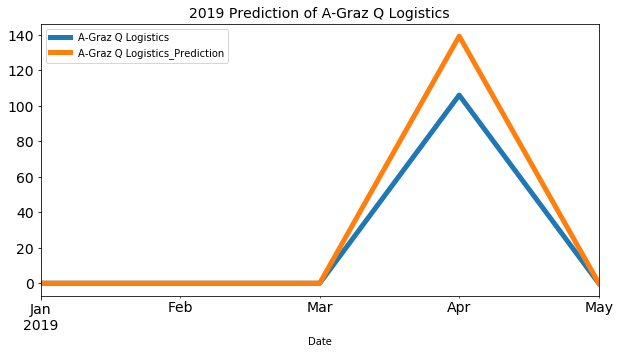

In [57]:
dep1_forecast = pd.DataFrame(dep1_forecast,index = test.index,columns=[depos[1] + '_Prediction'])
pd.concat([test1,dep1_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
plt.title('2019 Prediction of ' + depos[1], fontsize = 14)

In [58]:
for j in range(0,len(depos)):
    d = at_cb2016[[depos[i]]].dropna()
    

    print(d.index)

DatetimeIndex(['2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', '2016-12-31',
               '2017-01-31', '2017-02-28', '2017-03-31', '2017-04-30',
               '2017-05-31', '2017-06-30', '2017-07-31', '2017-08-31',
               '2017-09-30', '2017-10-31', '2017-11-30', '2017-12-31',
               '2018-01-31', '2018-02-28', '2018-03-31', '2018-04-30',
               '2018-05-31', '2018-06-30', '2018-07-31', '2018-08-31',
               '2018-09-30', '2018-10-31', '2018-11-30', '2018-12-31',
               '2019-01-31', '2019-02-28', '2019-03-31', '2019-04-30',
               '2019-05-31'],
              dtype='datetime64[ns]', name='Date', freq='M')
DatetimeIndex(['2016-01-31', '2016-02-29', '2016-03-31', '2016-04-30',
               '2016-05-31', '2016-06-30', '2016-07-31', '2016-08-31',
               '2016-09-30', '2016-10-31', '2016-11-30', 

In [59]:
optimal_test = list()
optimal_prediction = list()
opt_deps_forecast = list()
depo_train = list()
depo_test = list()
mse = list()

for f in range(0, len(depos)):
    dep = at_cb2016[[depos[f]]].dropna()
    my_train = dep.loc['2016-01-31':'2019-01-31']
    my_test = dep.loc['2019-02-28':]
    
    model_fit = opt_sarima_deps[f].fit(my_train)

    depo_forecast = model_fit.predict(n_periods=4)
    
    for col in range(len(depo_forecast)):
        if depo_forecast[col] < 0:
            depo_forecast[col] = 0
    
    opt_deps_forecast.append(depo_forecast)
    depo_train.append(my_train)
    depo_test.append(my_test)
    



In [60]:
depo_test

[name        A-Hörsching Schachinger
 Date                               
 2019-02-28                      375
 2019-03-31                       28
 2019-04-30                       60
 2019-05-31                      229, name        A-Graz Q Logistics
 Date                          
 2019-02-28                   0
 2019-03-31                   0
 2019-04-30                 106
 2019-05-31                   0]

In [61]:
opt_deps_forecast

[array([ 50.72261857,  68.43903886, 213.73790746,  53.30856126]),
 array([  0.        ,   0.        , 141.9425012 ,   2.34553721])]

In [62]:
depots_forecasts = pd.DataFrame()

In [63]:
for i in range(0, len(depos)):
    depots_forecasts[depos[i]] = opt_deps_forecast[i]
    

In [64]:
depots_forecasts

,A-Hörsching Schachinger,A-Graz Q Logistics
0,50.722619,0.000000
1,68.439039,0.000000
2,213.737907,141.942501
3,53.308561,2.345537


In [65]:
len(depo_test[0])

4

In [66]:
my_test

name,A-Graz Q Logistics
Date,
2019-02-28,0
2019-03-31,0
2019-04-30,106
2019-05-31,0


In [67]:
depots_forecasts['Date'] = my_test.index
depots_forecasts = depots_forecasts.set_index('Date')
depots_forecasts

,A-Hörsching Schachinger,A-Graz Q Logistics
Date,,
2019-02-28,50.722619,0.000000
2019-03-31,68.439039,0.000000
2019-04-30,213.737907,141.942501
2019-05-31,53.308561,2.345537


In [68]:
depots_forecasts.to_excel(r'/Users/mehrnazuser/Google Drive/BlueRock-Mehrnaz/Code/2excel/depots_forecasts.xlsx')

In [69]:
def plot_depo_prediction(depo_name, depo_test, depo_pred):
        pd.concat([depo_test, depo_pred], axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
        plt.title('2019 Prediction of ' + depo_name, fontsize = 14)        

In [70]:
depots_forecasts[[depos[0]]]

,A-Hörsching Schachinger
Date,
2019-02-28,50.722619
2019-03-31,68.439039
2019-04-30,213.737907
2019-05-31,53.308561


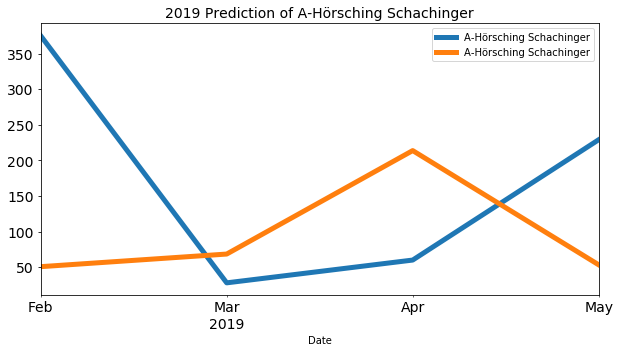

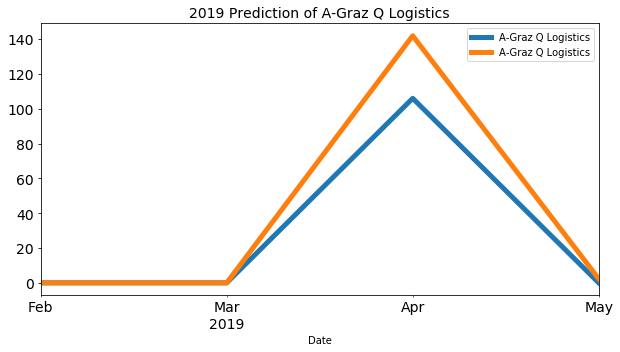

In [71]:
depos_mse = list()
for j in range(0, len(depos)):
    plot_depo_prediction(depos[j], depo_test[j], depots_forecasts[[depos[j]]])
    mse = mean_squared_error(depo_test[j], depots_forecasts[[depos[j]]])
    depos_mse.append(mse)

In [72]:
depos_mse

[40323.4904508064, 324.3412343705263]

In [73]:
norm = [i/sum(depos_mse) for i in depos_mse]
norm

[0.9920207002212911, 0.007979299778708837]

In [74]:
print('Normalized MSE of depots: ')
for r in range(0, len(depos)):
    print('\n ' + depos[r] + ' : ' + str(norm[r]))

i = norm.index(min(norm))
print('\n the MOST accurate : ' + depos[i])

j = norm.index(max(norm))
print('\n the LEAST accurate: ' + depos[j])

Normalized MSE of depots: 

 A-Hörsching Schachinger : 0.9920207002212911

 A-Graz Q Logistics : 0.007979299778708837

 the MOST accurate : A-Graz Q Logistics

 the LEAST accurate: A-Hörsching Schachinger


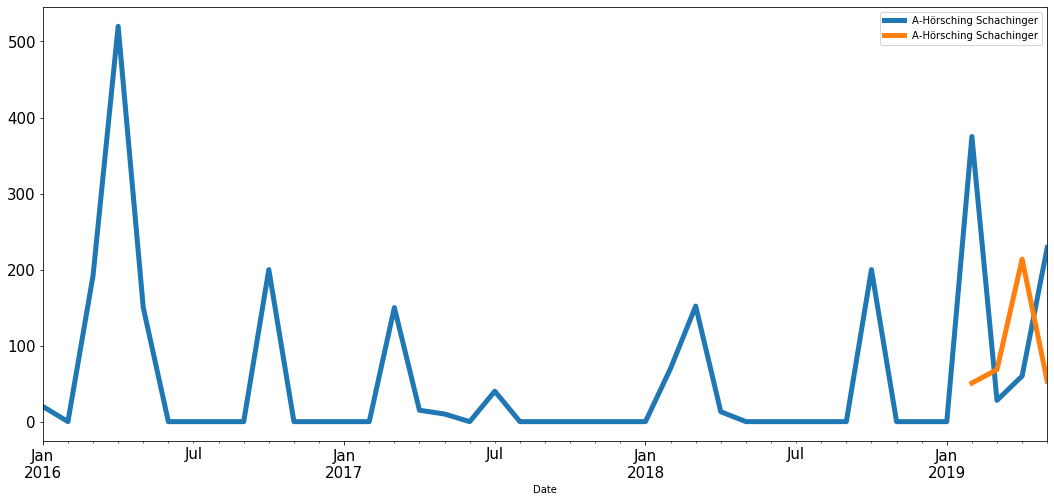

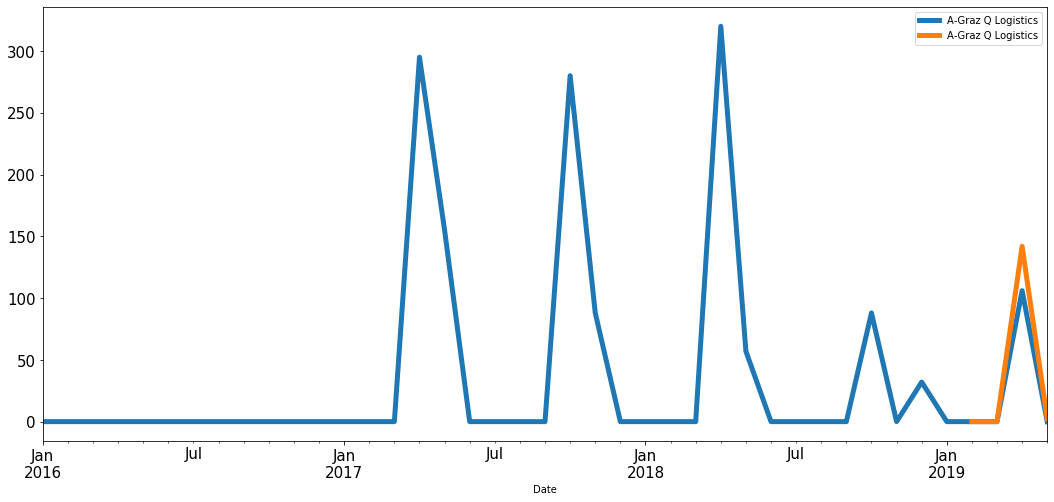

In [75]:
for s in range(0, len(depos)):
    pd.concat([at_cb2016[[depos[s]]], depots_forecasts[[depos[s]]]],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)

In [76]:
#depots_forecasts = depots_forecasts.drop('total', axis=1)

### Summation is NOT a good idea for France:

In [77]:
depots_forecasts['Austria'] = depots_forecasts.sum(axis=1)
depots_forecasts

,A-Hörsching Schachinger,A-Graz Q Logistics,Austria
Date,,,
2019-02-28,50.722619,0.000000,50.722619
2019-03-31,68.439039,0.000000,68.439039
2019-04-30,213.737907,141.942501,355.680409
2019-05-31,53.308561,2.345537,55.654098


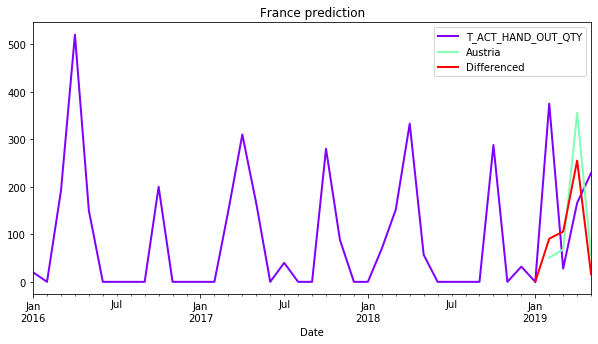

In [78]:
pd.concat([nl_cb_m, depots_forecasts['Austria'], future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')

# OLS

In [79]:
import statsmodels.api as sm

In [80]:
XVar = at_cb2016.drop('A-Hörsching Schachinger', axis = 1)
YVar = at_cb2016['A-Hörsching Schachinger']
YVar.head()

Date
2016-01-31     20
2016-02-29      0
2016-03-31    192
2016-04-30    520
2016-05-31    150
Freq: M, Name: A-Hörsching Schachinger, dtype: int64

In [81]:
XVar.head()

name,A-Graz Q Logistics
Date,
2016-01-31,0
2016-02-29,0
2016-03-31,0
2016-04-30,0
2016-05-31,0


In [82]:
linearModel = sm.OLS(YVar, XVar).fit()

In [83]:
print(linearModel.summary())

                                   OLS Regression Results                                   
Dep. Variable:     A-Hörsching Schachinger   R-squared (uncentered):                   0.005
Model:                                 OLS   Adj. R-squared (uncentered):             -0.019
Method:                      Least Squares   F-statistic:                             0.2193
Date:                     Mon, 06 Apr 2020   Prob (F-statistic):                       0.642
Time:                             17:34:28   Log-Likelihood:                         -256.64
No. Observations:                       41   AIC:                                      515.3
Df Residuals:                           40   BIC:                                      517.0
Df Model:                                1                                                  
Covariance Type:                 nonrobust                                                  
                         coef    std err          t      P>|t|      [0